<a href="https://colab.research.google.com/github/Riku-KANO/basic-ml-model/blob/main/optimization/gaussian_prosess_BO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ガウス過程回帰によるベイズ最適化

In [56]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import matplotlib.pyplot as plt
import typing
from copy import deepcopy

## ガウス過程回帰の実装

In [90]:
class GPRegressor:
  def __init__(self, x: np.array, y: np.array, kernel: str) -> None:
    self._size_check(x, y)
    self.x = x
    self.y = y
    self.size = x.shape[0]
    self.kernel = kernel
    self._update()

  def add_data(self, x: np.array, y: np.array) -> None:
    self._size_check(x, y)
    self.x = np.append(self.x, x)
    self.y = np.append(self.y, y)
    self.K = None
    self.size = self.x.shape[0]
    self._update()

  def predict(self, new_x: np.array) -> tuple:
    _x = new_x
    if type(_x) not in [np.array, np.ndarray]:
      if isinstance(new_x, list):
        _x = deepcopy(new_x)
        _x=np.array(new_x)
      elif type(new_x) is pd.Series:
        _x = new_x.values
      elif type(new_x) in [int, float]:
        _x = np.array(new_x)
      else:
        raise TypeError(f"The input type must be array-like object, not {type(new_x)}")

    test_size = _x.shape[0]
    mu = np.zeros(shape=(test_size))
    var = np.zeros(shape=(test_size))
    yy = np.dot(np.linalg.inv(self.K), self.y)
    for i in range(test_size):
      k = np.array([self._calc_kernel(self.x[j], _x[i]) for j in range(self.size)])
      s = self._calc_kernel(_x[i], _x[i])

      mu[i] = np.dot(k, yy)
      kK_ = np.dot(k, np.linalg.inv(self.K))
      var[i] = s - np.dot(kK_, k.T)

    return mu, var


  def _update(self) -> None:
    n_sz=self.x.shape[0]
    self.size = n_sz
    self.K = np.zeros(shape=(n_sz, n_sz))
    K = [[self._calc_kernel(self.x[i], self.x[j]) for i in range(n_sz)] for j in range(n_sz)]
    self.K=np.array(K)


  def _calc_kernel(self, x1: np.array, x2: np.array, b=1, sigma=20.): # TODO: カーネルの追加
    """ここではrbfカーネルを使う"""
    return b*np.exp(-np.dot(x1, x2)/sigma)

  def _size_check(self, x: np.array, y) -> None:
    if x.shape[0] != y.shape[0]:
      raise ValueError("The input (x, y) must have the same number of data.")
    return

  def __getitem__(self, idx):
    pass


## ベイズ最適化

### 獲得関数

#### PI (Probability of Inmprovement)
改善確率をもとに探索を行う時に用いる関数。
$$\text{PI}(x):=\Pr(f(x)=\mu>y_{max})$$
$f(x)$が正規分布$𝒩(\mu, \sigma^2)$に従うとする場合、標準正規分布に変換し、確率密度関数の面積を求めることで獲得関数を計算することができる。具体的には以下のような操作を行って獲得関数$a_{PI}$を計算する。
$$z=\frac{\mu-y_{max}}{\sigma}$$
$$a_{PI}(x_{n+1};x_{1:n})=Φ(z)$$
$$Φ(z)=∫^z_{-\infty}𝒩(x|0,1)dx$$

In [58]:
def PI(mu, var, y_best):
  z = (mu - y_best) / var 
  return scipy.stats.norm.cdf(z, 0, 1)

#### EI (Expected Improvement)
期待改善度に基づいて探索を行う時に用いる関数。
$$\text{EI}(x):=𝔼[\max(f(x)-y_{max}, 0)]$$
PIの場合と同様に$f(x)=\mu$が正規分布に従うとした場合、獲得関数$a_{EI}$は以下のように表される。
$$z=\frac{\mu-y_{max}}{\sigma}$$
$$a_{EI}(x_{n+1}; x_{1:n})=\sigma\times\left(z\cdotΦ(z)+ϕ(z)\right)$$
$$Φ(z)=∫^z_{-\infty}𝒩(x|0,1)dx$$
$$ϕ(z)=𝒩(x| 0, 1)$$

In [95]:
def EI(mu, var, y_best):
  z = (mu - y_best) / var
  return var * (z * scipy.stats.norm.cdf(z, 0, 1) + scipy.stats.norm.pdf(z, 0, 1)) 

#### UCB (Upper Confidence Band)
上側不確実性に基づいて行う楽観的探索に用いられる関数。
$$\text{UCB}(x):=\mu(x)+\beta\sigma(x)$$

In [12]:
def UCB(mu, var, beta=3):
  return mu + beta * var

### 最適化

ブラックボックスな関数はここでは以下のようにして定める。

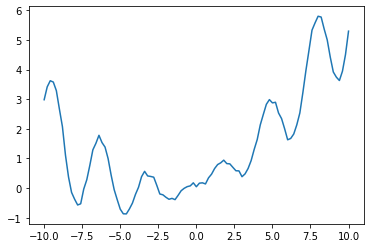

In [61]:
def BBF(x):
  if "__len__" in dir(x):
    return -2 * (x / 10) * np.cos(2 * x) + (x / 5) ** 2 + 2 * x / 10 + 0.2 * np.random.rand(len(x))
  else:
    return -2 * (x / 10) * np.cos(2 * x) + (x / 5) ** 2 + 2 * x / 10 + 0.2 * np.random.rand()

x_tmp = np.linspace(-10, 10, 101)
y_tmp = BBF(x_tmp)
plt.plot(x_tmp, y_tmp)

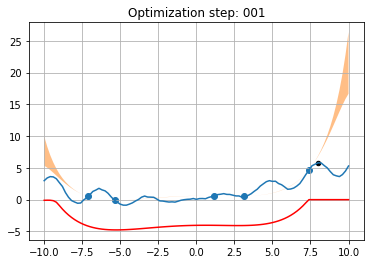

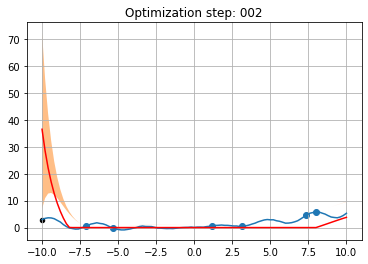

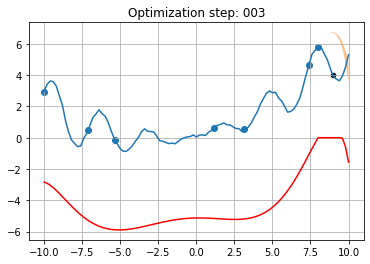

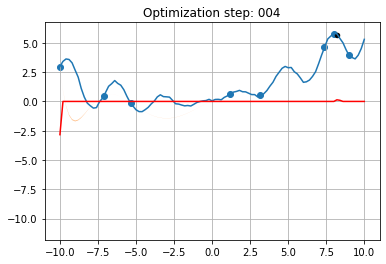

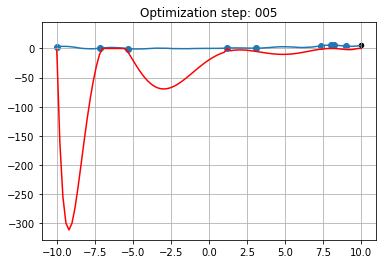

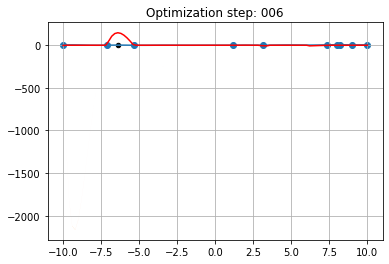

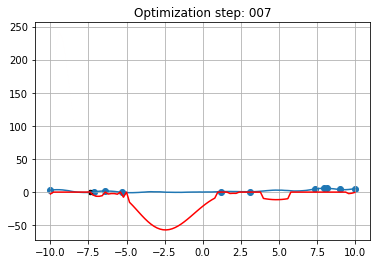

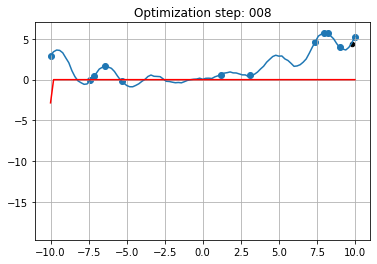

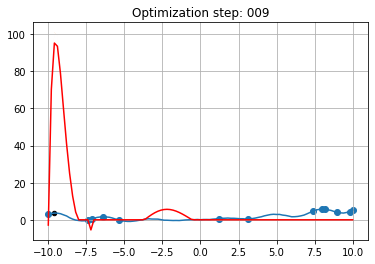

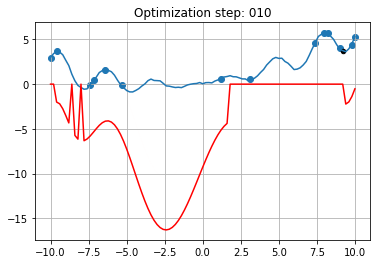

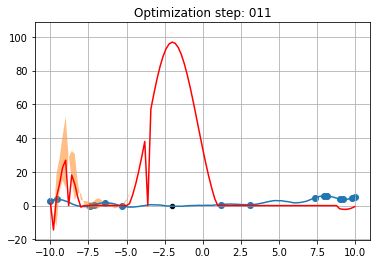

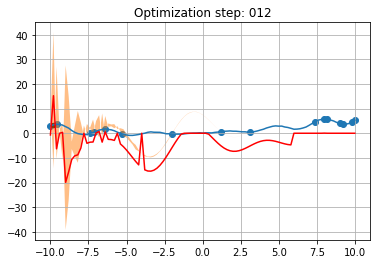

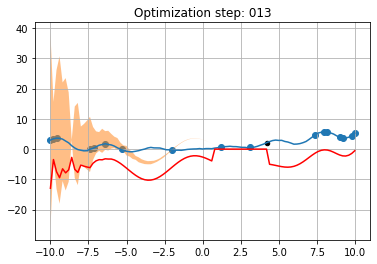

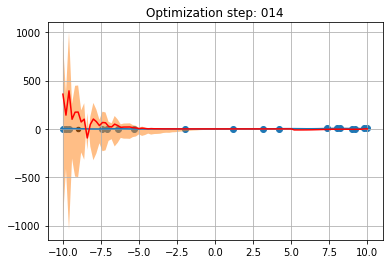

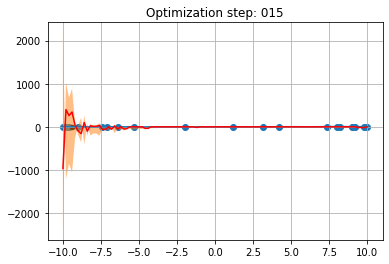

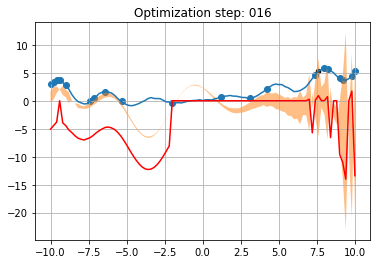

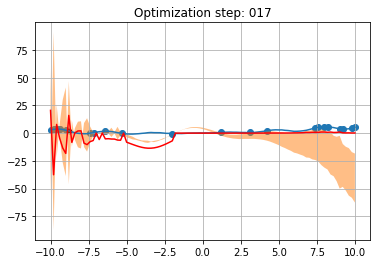

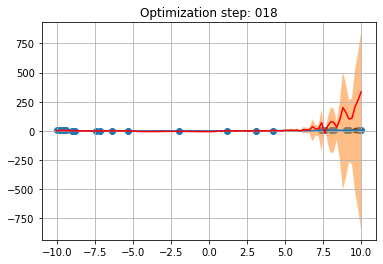

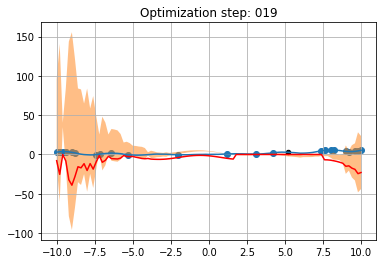

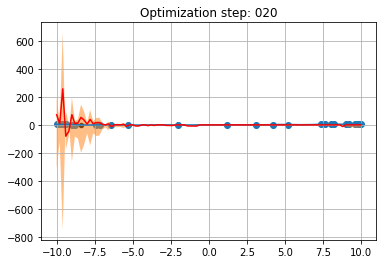

In [102]:
def plot_graph(x_tmp, y_tmp, x_points, y_points, mu, var, acq_score, next_x, next_y, step):
  plt.plot(x_tmp, y_tmp)
  plt.plot(x_tmp, acq_score, c="r")
  plt.scatter(x_points, y_points)
  plt.scatter(next_x, next_y, c="k", s=20)
  plt.fill_between(x_tmp, mu-var, mu+var, alpha=0.5)
  plt.title("Optimization step: {:03d}".format(step+1))
  plt.grid(True)
  plt.show()

NUM_LOOP = 20
SEED = 42
np.random.seed = 42

x_range = np.linspace(-10, 10, 101)

x_initial = np.random.rand(5) * 20 - 10
y_initial = BBF(x_initial)

searched = [False] * 101

gpr = GPRegressor(x_initial, y_initial, 'rbf')

for i in range(NUM_LOOP):
  x = gpr.x
  y = gpr.y
  mu, var = gpr.predict(x_range)
  y_best = np.max(y)
  acq_score = EI(mu, var, y_best)
  acq_score_with_id = [(acq_score[j], j) for j in range(len(acq_score))]
  acq_score_sorted = sorted(acq_score_with_id)[::-1]
  rank = 0
  while searched[acq_score_sorted[rank][1]]:
    rank+=1
  next_id=acq_score_sorted[rank][1]
  searched[next_id] = True
  x_next = np.array([x_range[next_id]])
  y_next = np.array([BBF(x_next)])
  plot_graph(x_tmp, y_tmp, gpr.x, gpr.y, mu, var, acq_score, x_next, y_next, i)

  gpr.add_data(x_next, y_next)
